In [37]:
import pandas as pd
import numpy as np

In [226]:
# filtered_edgelist_df = pd.read_csv('final_edgelist.csv')
filtered_edgelist_df = pd.read_csv('final_edgelist_gpt_o_mini_lista_cerrada_graph_machinelearning.csv')
print('Full edgelist len:', len(filtered_edgelist_df))
print('Liinked edgelist len:', len(filtered_edgelist_df[filtered_edgelist_df['sentiment'] != 'no_link_found']))
filtered_edgelist_df.sample(2)

Full edgelist len: 12083
Liinked edgelist len: 687


,parliamentarian_1,parliamentarian_2,proportion_agreement,region_1,region_2,partido_1,partido_2,Diputado_1,Diputado_2,sector_1,...,person_2,label,sentiment,in_degree_1,out_degree_1,in_degree_2,out_degree_2,total_degree_1,total_degree_2,common_neighbors
5434,"Jouannet, Andres","Mulet, Jaime",1.364954,Región de la Araucanía (11),Región de Atacama (5),Amarillos,FRVS,Andres Jouannet Valderrama,Jaime Mulet Martinez,centro_izquierda,...,NaN,NaN,no_link_found,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1945,"Mellado, Miguel","Schneider, Emilia",1.093544,Región de la Araucanía (11),Región Metropolitana de Santiago (47),RN,CS,Miguel Mellado Suazo,Emilia Schneider Videla,centro_derecha,...,NaN,NaN,no_link_found,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [227]:
# Similitud de partido (1 si son del mismo partido, 0 si no)
filtered_edgelist_df['same_party'] = (filtered_edgelist_df['partido_1'] == filtered_edgelist_df['partido_2']).astype(int)

# Similitud de sector político (1 si es el mismo sector, 0 si no)
filtered_edgelist_df['same_sector'] = (filtered_edgelist_df['sector_1'] == filtered_edgelist_df['sector_2']).astype(int)

# Similitud de región (1 si es la misma región, 0 si no)
filtered_edgelist_df['same_region'] = (filtered_edgelist_df['region_1'] == filtered_edgelist_df['region_2']).astype(int)


In [ ]:
# filtered_edgelist_df.rename(columns={'label': 'edge'}, inplace=True)


In [257]:
data = filtered_edgelist_df.dropna(subset=['in_degree_1'])
# Crear un diccionario de mapeo
sentiment_mapping = {'negative': -1, 'neutral': 0, 'positive': 1}

# Reemplazar los valores en la columna 'sentiment'
data['sentiment'] = data['sentiment'].map(sentiment_mapping)

# Verificar el resultado
print(data['sentiment'].value_counts())


sentiment
 1    412
-1    147
 0    128
Name: count, dtype: int64


C:\Users\benja\AppData\Local\Temp\ipykernel_15420\398554432.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'] = data['sentiment'].map(sentiment_mapping)


# Regresión con métricas de grafo

In [258]:
data = data[['proportion_agreement','in_degree_1', 'out_degree_1', 'in_degree_2', 'out_degree_2', 'total_degree_1', 'total_degree_2', 'common_neighbors', 'same_party', 'same_sector', 'same_region', 'sentiment']]


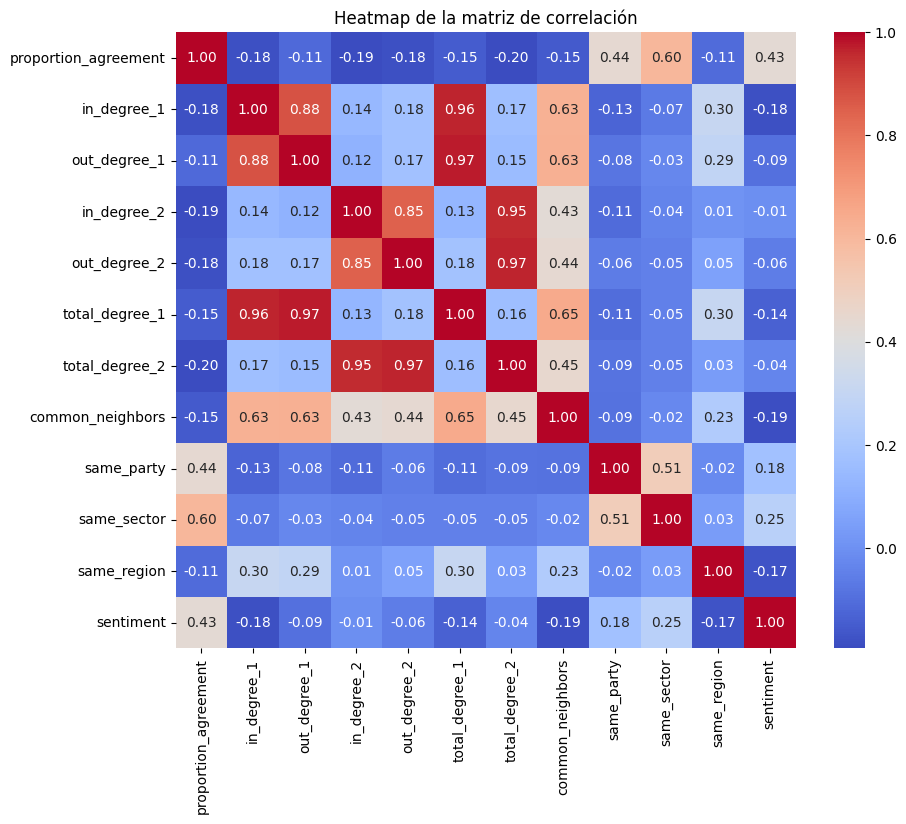

In [247]:
import seaborn as sns

# Matriz de correlación para todas las características
correlation_matrix = data.corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap de la matriz de correlación')
plt.show()


In [249]:

correlation_matrix = data.corr()

abs_correlation_matrix = correlation_matrix.abs()

for i in range(len(abs_correlation_matrix)):
    abs_correlation_matrix.iloc[i, i] = 0

top_correlations = abs_correlation_matrix.unstack().sort_values(ascending=False)

print("Las correlaciones más altas:")
print(top_correlations.head(20))


Las correlaciones más altas:
total_degree_1        out_degree_1            0.974426
out_degree_1          total_degree_1          0.974426
total_degree_2        out_degree_2            0.966731
out_degree_2          total_degree_2          0.966731
in_degree_1           total_degree_1          0.963441
total_degree_1        in_degree_1             0.963441
total_degree_2        in_degree_2             0.954498
in_degree_2           total_degree_2          0.954498
out_degree_1          in_degree_1             0.878597
in_degree_1           out_degree_1            0.878597
out_degree_2          in_degree_2             0.846461
in_degree_2           out_degree_2            0.846461
common_neighbors      total_degree_1          0.647414
total_degree_1        common_neighbors        0.647414
common_neighbors      out_degree_1            0.628867
out_degree_1          common_neighbors        0.628867
in_degree_1           common_neighbors        0.626117
common_neighbors      in_degree_1   

In [259]:
data = data[['proportion_agreement','in_degree_1', 'out_degree_1', 'in_degree_2', 'out_degree_2',  'common_neighbors', 'same_party', 'same_sector', 'same_region', 'sentiment']]


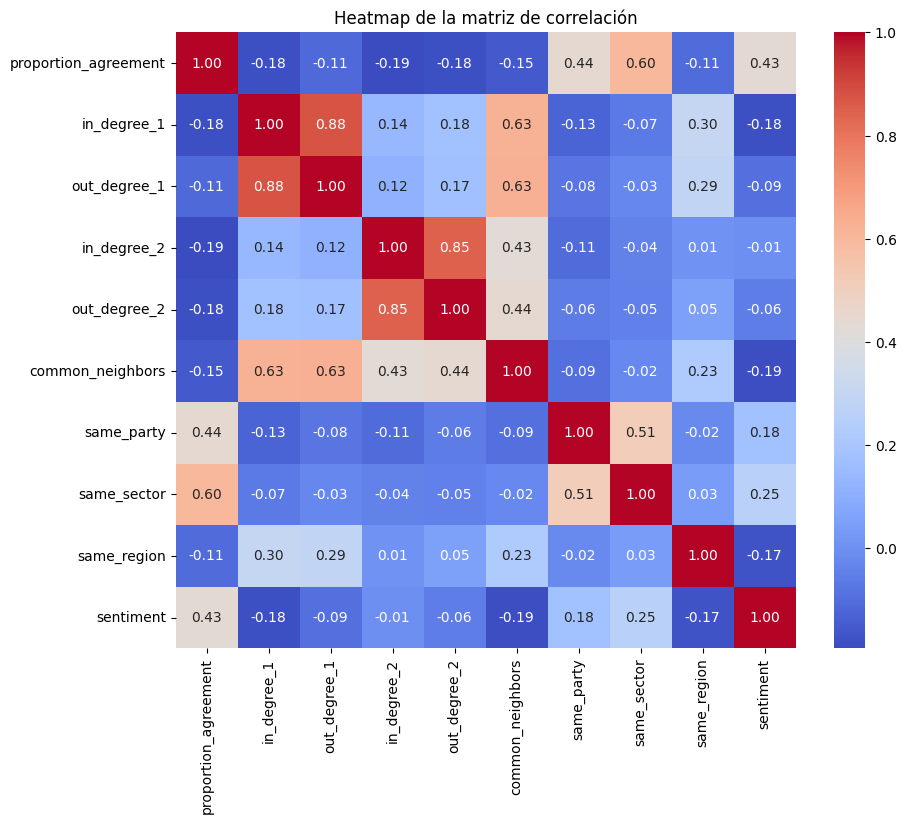

In [260]:
import seaborn as sns

# Matriz de correlación para todas las características
correlation_matrix = data.corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap de la matriz de correlación')
plt.show()

In [261]:
# X: Conjunto de características
# y: Variable objetivo (proportion_agreement)


X = data[['in_degree_1', 'out_degree_1', 'in_degree_2', 'out_degree_2',  'common_neighbors', 'same_party', 'same_sector', 'same_region', 'sentiment']]
y = data['proportion_agreement']



In [262]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb
import pandas as pd


In [269]:

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Definición ampliada de los hiperparámetros para probar
param_distributions = {
    'max_depth': [3, 5, 7, 9, 12, 15, 20, 25, 30],
    'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700, 800],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5, 1.0, 1.5],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7],
    'alpha': [0, 1, 5, 10, 15, 20]
}

# Búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=xg_reg, 
    param_distributions=param_distributions, 
    n_iter=200, 
    scoring='r2',  
    cv=5, 
    verbose=1, 
    random_state=42
)

random_search.fit(X_train, y_train)

results = random_search.cv_results_

results_df = pd.DataFrame({
    'mean_test_score': results['mean_test_score'],
    'params': results['params']
})

# Ordenar el DataFrame por 'mean_test_score' en orden descendente
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

# Imprimir los resultados ordenados
for index, row in results_df.iterrows():
    print(f"Score (R^2): {row['mean_test_score']:.4f}, Hiperparámetros: {row['params']}")



Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\Users\benja\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Score (R^2): 0.6486, Hiperparámetros: {'subsample': 0.7, 'n_estimators': 600, 'min_child_weight': 4, 'max_depth': 20, 'learning_rate': 0.15, 'gamma': 0, 'colsample_bytree': 0.8, 'alpha': 1}
Score (R^2): 0.6435, Hiperparámetros: {'subsample': 0.7, 'n_estimators': 700, 'min_child_weight': 4, 'max_depth': 30, 'learning_rate': 0.15, 'gamma': 0, 'colsample_bytree': 1.0, 'alpha': 1}
Score (R^2): 0.6347, Hiperparámetros: {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.4, 'gamma': 0, 'colsample_bytree': 0.6, 'alpha': 1}
Score (R^2): 0.6251, Hiperparámetros: {'subsample': 1.0, 'n_estimators': 800, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8, 'alpha': 1}
Score (R^2): 0.6225, Hiperparámetros: {'subsample': 0.5, 'n_estimators': 800, 'min_child_weight': 5, 'max_depth': 20, 'learning_rate': 0.15, 'gamma': 0, 'colsample_bytree': 1.0, 'alpha': 1}
Score (R^2): 0.6146, Hiperparámetros: {'subsample': 1

In [264]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo XGBoost Regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', subsample= 0.8, colsample_bytree=0.7, learning_rate=0.1,
                          max_depth=5, alpha=1, n_estimators=100, min_child_weight=4, gamma=0)

xg_reg.fit(X_train, y_train)


# Predecir en el conjunto de entrenamiento
y_train_pred = xg_reg.predict(X_train)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)

# Predecir en el conjunto de validación/prueba
y_test_pred = xg_reg.predict(X_test)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
# Calcular métricas
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"RMSE Entrenamiento: {train_rmse}")
print(f"RMSE Prueba: {test_rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

RMSE Entrenamiento: 0.13446968241954974
RMSE Prueba: 0.20113279157100217
MAE: 0.15668054184330282
R²: 0.6566526309498356


c:\Users\benja\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\benja\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


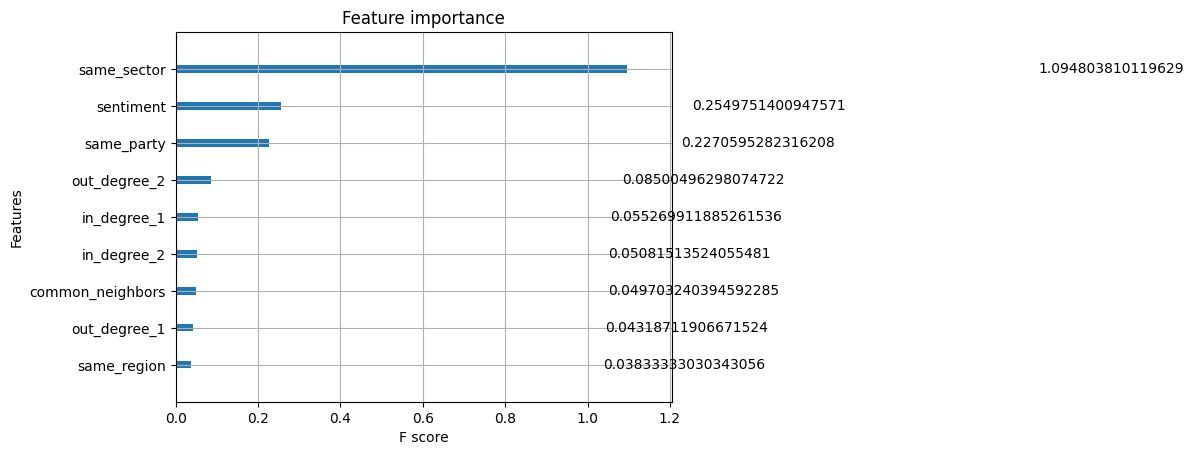

In [265]:
xgb.plot_importance(xg_reg, importance_type='gain', max_num_features=10)  
plt.show() #El aumento promedio en la métrica de rendimiento que se obtiene al usar una característica.


In [266]:
from sklearn.model_selection import cross_val_score
# Validación cruzada
cv_scores = cross_val_score(xg_reg, X, y, cv=5, scoring='neg_mean_squared_error')

# Convertir scores negativos a positivos y calcular el RMSE
cv_rmse = np.sqrt(-cv_scores)

print(f"RMSE de Validación Cruzada: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")

RMSE de Validación Cruzada: 0.2982 ± 0.1125


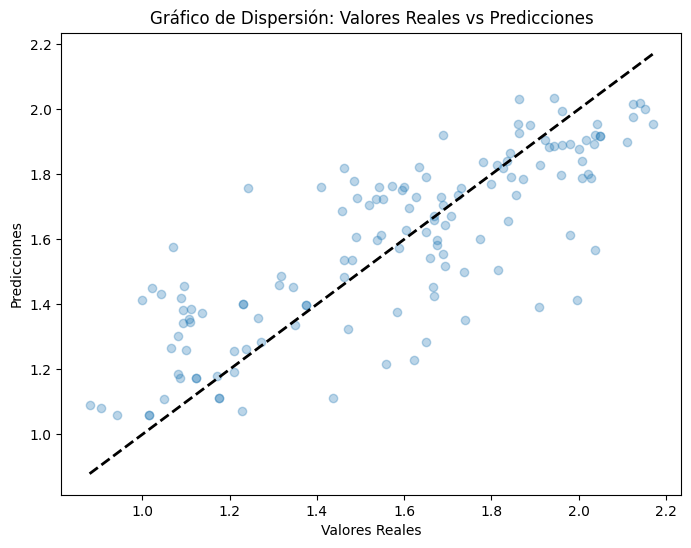

In [267]:
import matplotlib.pyplot as plt

# Predecir en el conjunto de prueba
y_test_pred = xg_reg.predict(X_test)

# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Gráfico de Dispersión: Valores Reales vs Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea diagonal
plt.show()


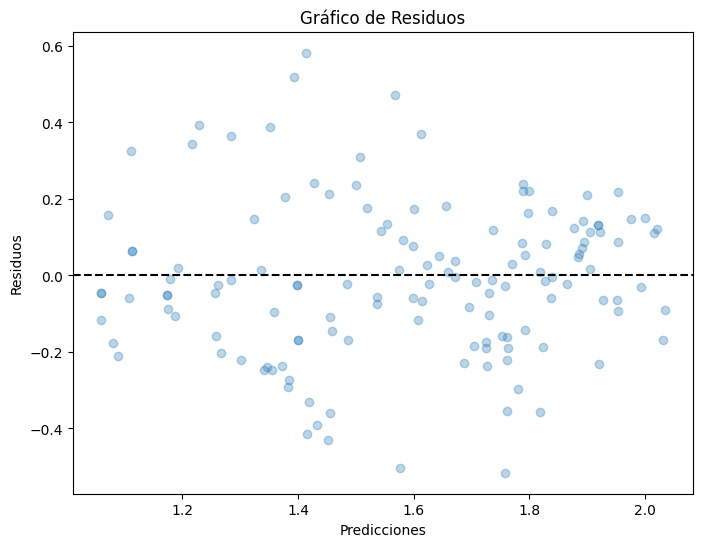

In [268]:
# Calcular residuos
residuals = y_test - y_test_pred

# Crear el gráfico de residuos
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, residuals, alpha=0.3)
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.axhline(y=0, color='k', linestyle='--')  # Línea horizontal en 0
plt.show()


# Regresión sin métricas de grafo

In [219]:
datos = data[['proportion_agreement','same_party', 'same_sector', 'same_region', 'sentiment']]
# X: Conjunto de características (todas las columnas que has calculado)
# y: Variable objetivo (proportion_agreement)


X = datos[['same_party', 'same_sector', 'same_region', 'sentiment']]
y = datos['proportion_agreement']



In [220]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo XGBoost Regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', subsample= 0.8, colsample_bytree=0.7, learning_rate=0.1,
                          max_depth=5, alpha=1, n_estimators=100, min_child_weight=4, gamma=0)

xg_reg.fit(X_train, y_train)


# Predecir en el conjunto de entrenamiento
y_train_pred = xg_reg.predict(X_train)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)

# Predecir en el conjunto de validación/prueba
y_test_pred = xg_reg.predict(X_test)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
# Calcular métricas
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"RMSE Entrenamiento: {train_rmse}")
print(f"RMSE Prueba: {test_rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

RMSE Entrenamiento: 0.23280579058976555
RMSE Prueba: 0.23274316537310588
MAE: 0.1864668693801699
R²: 0.5402498979048536


c:\Users\benja\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\benja\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


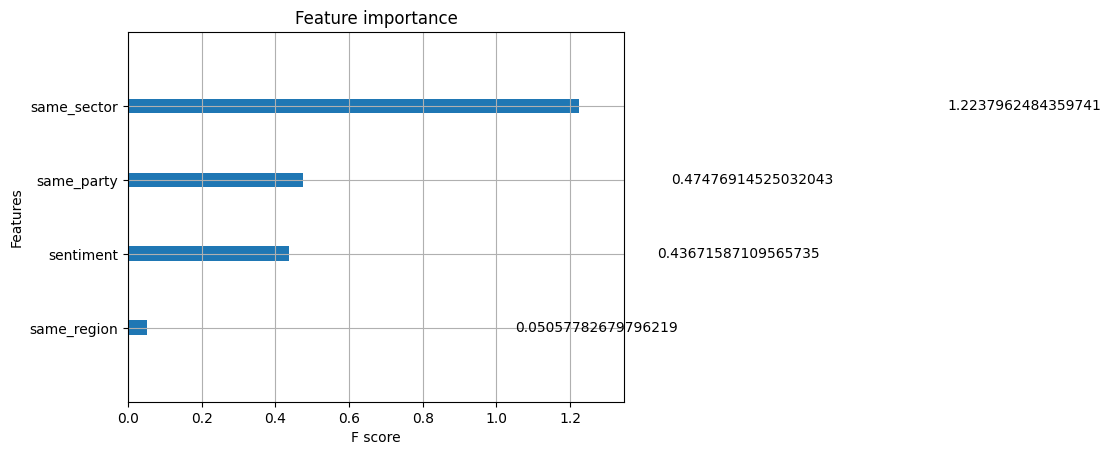

In [221]:
xgb.plot_importance(xg_reg, importance_type='gain', max_num_features=10)  
plt.show()

In [200]:
# Configuración del modelo XGBoost
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Definición ampliada de los hiperparámetros para probar
param_distributions = {
    'max_depth': [3, 5, 7, 9, 12, 15, 20, 25, 30],
    'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700, 800],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5, 1.0, 1.5],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7],
    'alpha': [0, 1, 5, 10, 15, 20]
}

# Búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=xg_reg, 
    param_distributions=param_distributions, 
    n_iter=200, 
    scoring='r2', 
    cv=5, 
    verbose=1, 
    random_state=42
)

random_search.fit(X_train, y_train)

results = random_search.cv_results_

results_df = pd.DataFrame({
    'mean_test_score': results['mean_test_score'],
    'params': results['params']
})

results_df = results_df.sort_values(by='mean_test_score', ascending=False)

# Imprimir los resultados ordenados
for index, row in results_df.iterrows():
    print(f"Score (R^2): {row['mean_test_score']:.4f}, Hiperparámetros: {row['params']}")


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Score (R^2): 0.4479, Hiperparámetros: {'subsample': 0.7, 'n_estimators': 700, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.9, 'alpha': 0}
Score (R^2): 0.4471, Hiperparámetros: {'subsample': 0.5, 'n_estimators': 700, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.9, 'alpha': 1}
Score (R^2): 0.4466, Hiperparámetros: {'subsample': 0.7, 'n_estimators': 600, 'min_child_weight': 4, 'max_depth': 20, 'learning_rate': 0.15, 'gamma': 0, 'colsample_bytree': 0.8, 'alpha': 1}
Score (R^2): 0.4459, Hiperparámetros: {'subsample': 1.0, 'n_estimators': 800, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8, 'alpha': 1}
Score (R^2): 0.4458, Hiperparámetros: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 4, 'max_depth': 15, 'learning_rate': 0.4, 'gamma': 0, 'colsample_bytree': 0.9, 

In [222]:
from sklearn.model_selection import cross_val_score
# Validación cruzada
cv_scores = cross_val_score(xg_reg, X, y, cv=5, scoring='neg_mean_squared_error')

# Convertir scores negativos a positivos y calcular el RMSE
cv_rmse = np.sqrt(-cv_scores)

print(f"RMSE de Validación Cruzada: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")

RMSE de Validación Cruzada: 0.3025 ± 0.1126


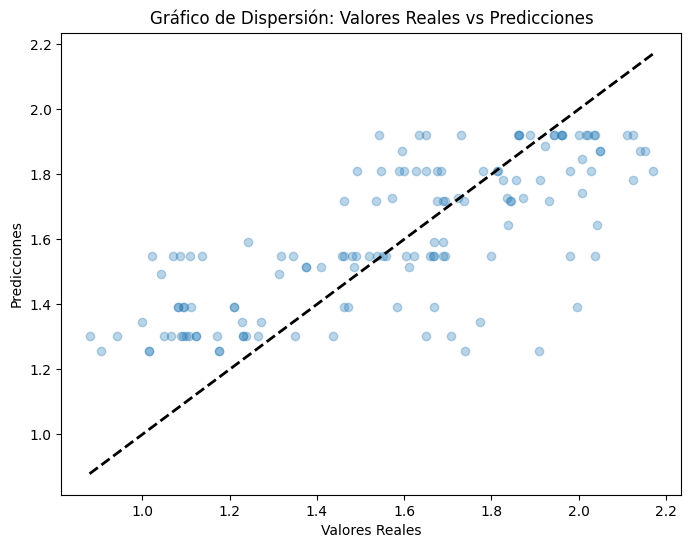

In [223]:
import matplotlib.pyplot as plt

# Predecir en el conjunto de prueba
y_test_pred = xg_reg.predict(X_test)

# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Gráfico de Dispersión: Valores Reales vs Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea diagonal
plt.show()


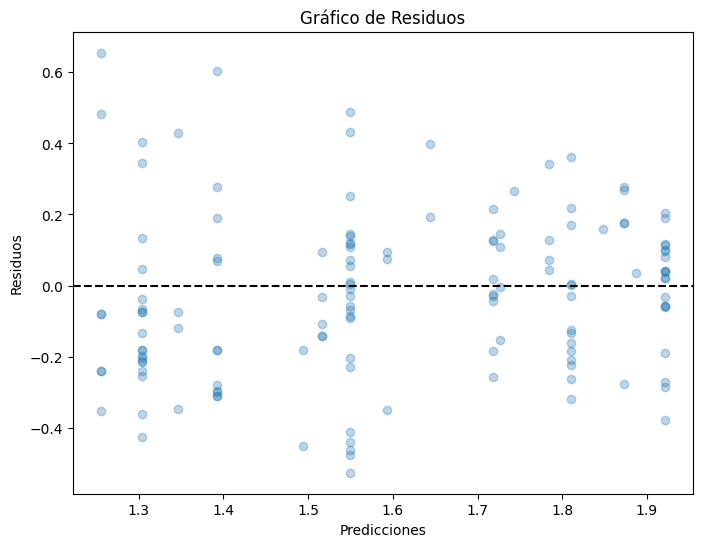

In [224]:
# Calcular residuos
residuals = y_test - y_test_pred

# Crear el gráfico de residuos
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, residuals, alpha=0.3)
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.axhline(y=0, color='k', linestyle='--')  # Línea horizontal en 0
plt.show()
